# ASSIGNMENT 5

## Import Libraries

In [21]:
import itertools
import heapq
import random
import time
import networkx as nx
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

## Dataset Setup

In [2]:
# Locations

locations = ['Warehouse', 'C1', 'C2', 'C3']

# Distance matrix
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

# Parcel information
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15},
}

vehicle_capacity = 30

## Recurrence-Based Route Cost Estimation

In [4]:
def delivery_cost(current, visited, dp):
    state = (current, tuple(sorted(visited)))
    if state in dp:
        return dp[state]

    if len(visited) == len(locations):
        return distance_matrix[current][0]

    best = float('inf')
    for nxt in range(1, len(locations)):
        if nxt not in visited:
            cost = distance_matrix[current][nxt] + delivery_cost(nxt, visited | {nxt}, dp)
            best = min(best, cost)

    dp[state] = best
    return best

dp = {}
recurrence_result = delivery_cost(0, {0}, dp)
recurrence_result


18

## Greedy Parcel Selection (Knapsack)

In [5]:
def greedy_select(parcels, capacity):
    ratio = []
    for c, info in parcels.items():
        v = info['value']
        w = info['weight']
        ratio.append((v/w, c))

    ratio.sort(reverse=True)
    
    selected = []
    current_weight = 0
    
    for r, c in ratio:
        if current_weight + parcels[c]['weight'] <= capacity:
            selected.append(c)
            current_weight += parcels[c]['weight']
    
    return selected

selected_parcels = greedy_select(parcels, vehicle_capacity)
selected_parcels

['C1', 'C2']

## DP for Knapsack (Used for Time Complexity Growth)

In [19]:
def knapsack_dp(values, weights, capacity):
    n = len(values)
    dp = [[0]*(capacity+1) for _ in range(n+1)]
    
    for i in range(1, n+1):
        for w in range(capacity+1):
            if weights[i-1] <= w:
                dp[i][w] = max(values[i-1] + dp[i-1][w - weights[i-1]], dp[i-1][w])
            else:
                dp[i][w] = dp[i-1][w]
    
    return dp[n][capacity]


## DP Time Growth Graph

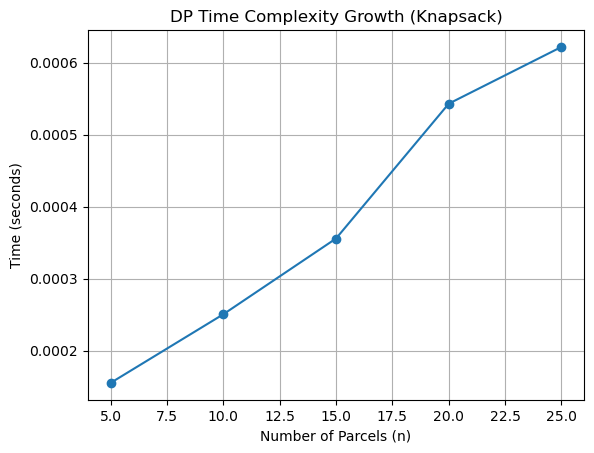

In [22]:
sizes = [5, 10, 15, 20, 25]
times_knap = []

for n in sizes:
    values = [random.randint(10,100) for _ in range(n)]
    weights = [random.randint(5,30) for _ in range(n)]
    capacity = 50
    
    t0 = time.perf_counter()
    knapsack_dp(values, weights, capacity)
    t1 = time.perf_counter()
    
    times_knap.append(t1 - t0)

plt.plot(sizes, times_knap, marker='o')
plt.xlabel("Number of Parcels (n)")
plt.ylabel("Time (seconds)")
plt.title("DP Time Complexity Growth (Knapsack)")
plt.grid(True)
plt.show()


## Parcel Value vs Weight

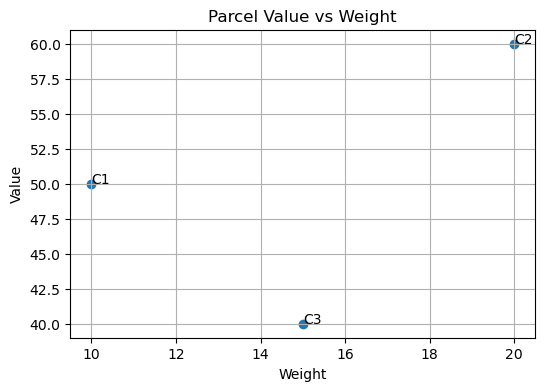

In [26]:
values = [parcels[c]['value'] for c in parcels]
weights = [parcels[c]['weight'] for c in parcels]
labels = list(parcels.keys())

plt.figure(figsize=(6,4))
plt.scatter(weights, values)

for i, label in enumerate(labels):
    plt.annotate(label, (weights[i], values[i]))

plt.xlabel("Weight")
plt.ylabel("Value")
plt.title("Parcel Value vs Weight")
plt.grid(True)
plt.show()


## DP for Time-Window Feasibility

In [7]:
def check_time_windows(route, parcels):
    time = 9  # starting time
    for loc in route[1:-1]:  # excluding warehouse
        earliest, latest = parcels[loc]['time']
        if not (earliest <= time <= latest):
            return False
        time += 1  # assume 1 unit travel
    return True

test_route = ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
result = check_time_windows(test_route, parcels)

print("Route:", test_route)
print("Time-Window Feasible:", result)

Route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
Time-Window Feasible: True


## Profiling DP Time Growth

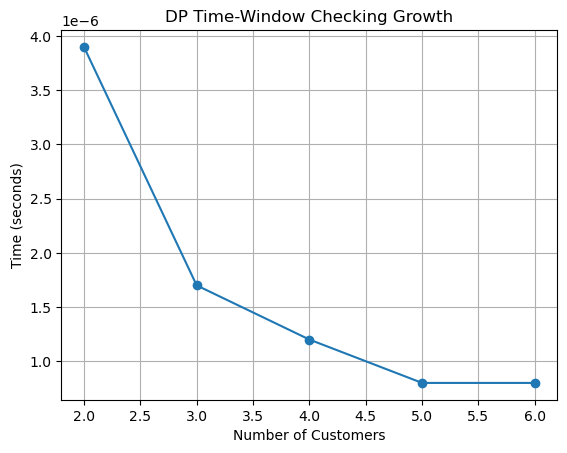

In [17]:
# DP Time Growth Graph
sizes = [2, 3, 4, 5, 6]
times_dp = []

def dp_simulation(n):
    # Simulate increasing DP work
    dummy_parcels = {f"C{i}": {'time': (9+i, 12+i)} for i in range(1, n)}
    route = ['Warehouse'] + list(dummy_parcels.keys()) + ['Warehouse']
    t0 = time.perf_counter()
    check_time_windows(route, dummy_parcels)
    t1 = time.perf_counter()
    return t1 - t0

for s in sizes:
    times_dp.append(dp_simulation(s))

plt.plot(sizes, times_dp, marker='o')
plt.title("DP Time-Window Checking Growth")
plt.xlabel("Number of Customers")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.show()

## Delivery Success Within Time Window Graph

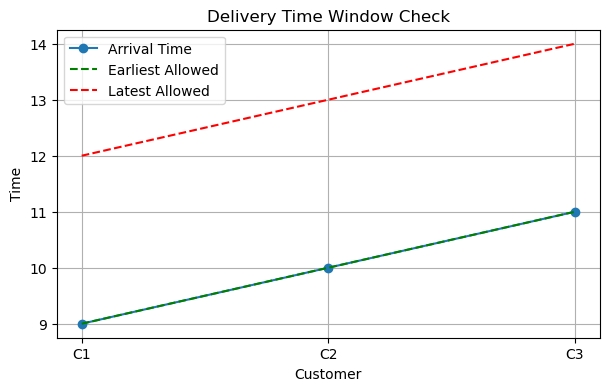

In [18]:
# Delivery Success Visualization
labels = ['C1', 'C2', 'C3']
arrival_times = [9, 10, 11]

earliest = [parcels[c]['time'][0] for c in labels]
latest = [parcels[c]['time'][1] for c in labels]

plt.figure(figsize=(7,4))
plt.plot(labels, arrival_times, marker='o', label="Arrival Time")
plt.plot(labels, earliest, '--g', label="Earliest Allowed")
plt.plot(labels, latest, '--r', label="Latest Allowed")
plt.title("Delivery Time Window Check")
plt.xlabel("Customer")
plt.ylabel("Time")
plt.legend()
plt.grid(True)
plt.show()

## Dijkstra Shortest Path (Graph Algorithms)

In [8]:
def dijkstra(adj, source):
    dist = {node: float('inf') for node in adj}
    dist[source] = 0
    pq = [(0, source)]

    while pq:
        d, node = heapq.heappop(pq)
        if d > dist[node]:
            continue
        
        for neigh, w in adj[node]:
            nd = d + w
            if nd < dist[neigh]:
                dist[neigh] = nd
                heapq.heappush(pq, (nd, neigh))
    
    return dist

# Convert matrix to adjacency list
adj = {}
for i in range(len(locations)):
    adj[locations[i]] = []
    for j in range(len(locations)):
        if i != j:
            adj[locations[i]].append((locations[j], distance_matrix[i][j]))

dijkstra_result = dijkstra(adj, 'Warehouse')
dijkstra_result


{'Warehouse': 0, 'C1': 4, 'C2': 8, 'C3': 6}

## Prim’s MST Algorithm

In [25]:
def prim_mst(adj):
    start = list(adj.keys())[0]
    visited = {start}
    pq = []
    
    for neigh, w in adj[start]:
        heapq.heappush(pq, (w, start, neigh))

    mst_cost = 0
    edges = []

    while pq:
        w, u, v = heapq.heappop(pq)
        if v in visited:
            continue
        visited.add(v)
        mst_cost += w
        edges.append((u, v, w))

        for neigh, w2 in adj[v]:
            if neigh not in visited:
                heapq.heappush(pq, (w2, v, neigh))

    return mst_cost, edges

mst_cost, mst_edges = prim_mst(adj)
mst_cost, mst_edges

(12, [('Warehouse', 'C1', 4), ('C1', 'C2', 5), ('C2', 'C3', 3)])

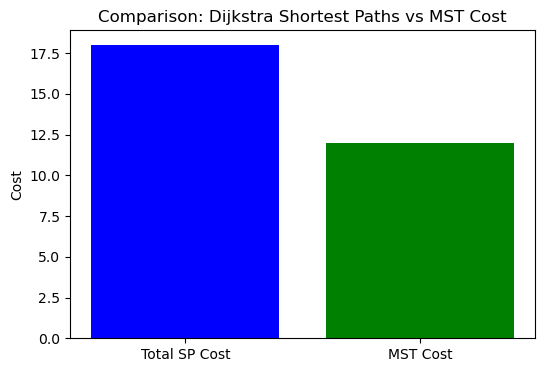

In [14]:
# GRAPH 3: Dijkstra vs MST Cost Comparison
sp_cost = sum(dijkstra_result.values())  # total shortest-path distance
mst_cost = mst_cost                      # from your Prim's output

plt.figure(figsize=(6,4))
plt.bar(["Total SP Cost", "MST Cost"], [sp_cost, mst_cost], color=['blue','green'])
plt.title("Comparison: Dijkstra Shortest Paths vs MST Cost")
plt.ylabel("Cost")
plt.show()


## TSP — Brute Force (Exact Optimal Route)

In [10]:
def tsp_bruteforce(locations, distance_matrix):
    n = len(locations)
    customers = list(range(1, n))
    best_cost = float('inf')
    best_route = None

    for perm in itertools.permutations(customers):
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm) - 1):
            cost += distance_matrix[perm[i]][perm[i+1]]
        cost += distance_matrix[perm[-1]][0]

        if cost < best_cost:
            best_cost = cost
            best_route = perm

    final_route = ['Warehouse'] + [locations[i] for i in best_route] + ['Warehouse']
    return final_route, best_cost

route, cost = tsp_bruteforce(locations, distance_matrix)
route, cost


(['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'], 18)

## ROUTE MAP VISUALIZATION

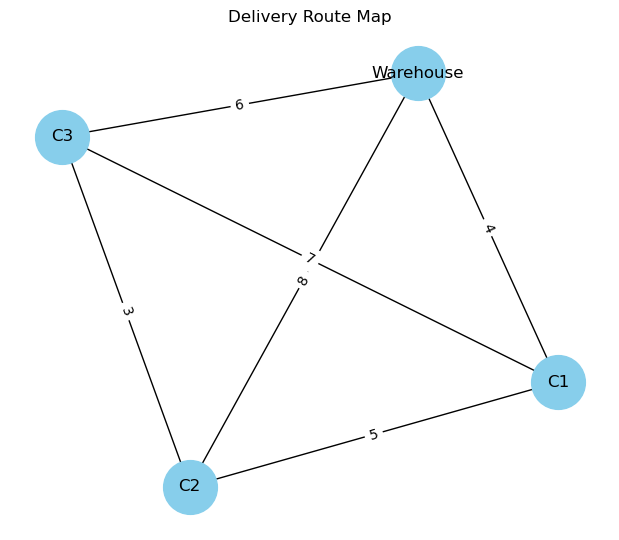

In [16]:
G = nx.Graph()

# Add nodes
for loc in locations:
    G.add_node(loc)

# Add edges from distance matrix
for i in range(len(locations)):
    for j in range(i+1, len(locations)):
        G.add_edge(locations[i], locations[j], weight=distance_matrix[i][j])

# Plot
pos = nx.spring_layout(G, seed=42)
weights = nx.get_edge_attributes(G, 'weight')

plt.figure(figsize=(6,5))
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue')
nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
plt.title("Delivery Route Map")
plt.show()

## Time & Memory Profiling

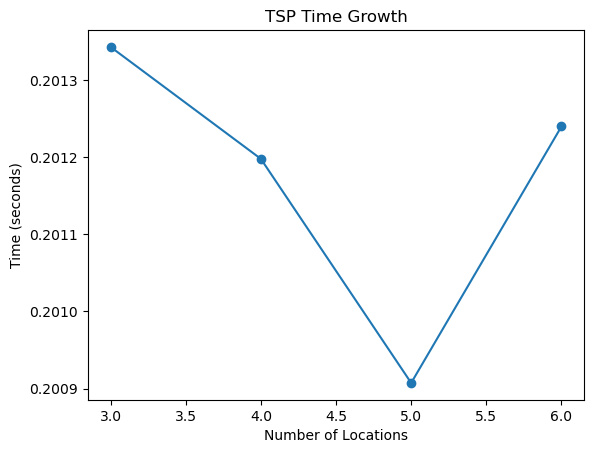

In [11]:
def profile(func, *args):
    t0 = time.perf_counter()
    mem_before = memory_usage()[0]
    
    result = func(*args)

    mem_after = memory_usage()[0]
    t1 = time.perf_counter()

    return result, t1 - t0, mem_after - mem_before

sizes = [3, 4, 5, 6]
times = []

for n in sizes:
    locs = ['W'] + [f'C{i}' for i in range(1, n)]
    dist = [[0 if i==j else abs(i-j)+1 for j in range(n)] for i in range(n)]
    _, t, _ = profile(tsp_bruteforce, locs, dist)
    times.append(t)

plt.plot(sizes, times, marker='o')
plt.xlabel("Number of Locations")
plt.ylabel("Time (seconds)")
plt.title("TSP Time Growth")
plt.show()
